# Starbucks Capstone Challenge

# **Table of Contents**
1. [Introduction](#intro)
1. [Business Understanding](#business)
1. [Data Preparation](#prepare)
1. [Analisys Data](#EDA)
    1. [Are neighborhoods important in get better housing?](#housing)
    1. [What is the evolution of the different types in Airbnb in Seatle?](#evolution)
    1. [What is the season of the year which it is more occupied?](#season)
1. [Model Data](#model)
1. [Conclusion](#conclusion)

## Introduction
<a id="intro"></a>

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Problem

My task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.  

Ademas de este analisis de los datos, voy a querer predecir cuando un usuario va a realizar el evento de completar, este modelo seria bastante util ya que podriamos predecir que personas las completan o no, asi evitar enviar ofertas a personas que no las completara.

### Solution

Para resolver este problema que nos hemos propuesto, previamente voy a tener que realizar un gran proceso de preprocesamiento y limpieza de los datos, a partir de los datos limpios voy a poder realizar estadisticas de estos y resolver algunas preguntas que tendre.  
Y finalmente realizare un modelo predictivo binario (completar o no completar), para poder predicir cuando un usuario va a realizar una oferta por completo. Esto nos ayudara a saber cuando se acaban las ofertas a los clientes para poder proporcionales otras mas adelante.


## Business Understanding
<a id="business"></a>

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Vamos a realizar la importancion de las librerias y a cargar los datasets en formato Json.

In [237]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import seaborn as sns
from datetime import datetime

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio Dataset

Este dataset tiene la informacion de todas las ofertas que se van a usar y su descripcion.

In [238]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


In [239]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Como se puede observar este dataset esta compuesto por 10 filas y 6 columnas y no tiene valores nulos.

In [240]:
portfolio.describe(include="all")

,reward,channels,difficulty,duration,offer_type,id
count,10.000000,10,10.000000,10.000000,10,10
unique,NaN,4,NaN,NaN,3,10
top,NaN,"[web, email, mobile, social]",NaN,NaN,bogo,3f207df678b143eea3cee63160fa8bed
freq,NaN,4,NaN,NaN,4,1
mean,4.200000,NaN,7.700000,6.500000,NaN,NaN
std,3.583915,NaN,5.831905,2.321398,NaN,NaN
min,0.000000,NaN,0.000000,3.000000,NaN,NaN
25%,2.000000,NaN,5.000000,5.000000,NaN,NaN
50%,4.000000,NaN,8.500000,7.000000,NaN,NaN
75%,5.000000,NaN,10.000000,7.000000,NaN,NaN


In [241]:
portfolio["offer_type"].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

* offer_type : la principal tipo de oferta es la bogo, con una frecuencia de 4 ofertas de este tipo, ademas debemos saber que solo existe 3 tipos de ofertas ('bogo', 'informational', 'discount').
* difficulty : la mayoria del dataset esta constituida por ofertas que se deben gastar mas de 8.5 dolares y su valor maximo es de 20.
* reward : La mayoria de las recompesas esta constituida entre 4 y 5 dolares y su valor maximo es de 10.
* duration : La mayoria de las recompesas esta constituida en 7 dolares y su valor maximo es de 10.
* channels : los canales mas frecuentes son las ofertas que estan en web, email, mobile, social.

### Profile Dataset

Este dataset tiene la informacion de todos los clientes y su descripcion.

In [242]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [243]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [244]:
profile.isna().sum()/profile.shape[0]

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

Como se puede observar este dataset esta compuesto por 17000 y 5 columnas, ademas contiene valores nulos en las variables gender and income representa el 12.7% del dataset, que coincide el mismo numero de valores nulos, en el apartado de preprocesamiento analizare en profundidad este caso de valores nulos.

In [245]:
profile.describe(include="all")

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,def5cb0357014a2a8df9b8086810729c,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


* age : La edad media de los clientes esta puesta en lo 58 años y su maximo es de 118 años.
* gender : el genero mas frecuente es el masculino, teniendo un porcentaje de 49%, y tenemos 3 valores de genero (masculino, femenino y otro)
* income : la mitad de los clientes tiene unos ingresos de 64000 y su maximo es de 120000.

### Transcript Dataset

Este dataset tiene la informacion de todas las transacciones de Starbucks en funcion del tiempo.

In [246]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [247]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Como se puede observar este dataset esta compuesto por 306534 filas y 4 columnas y no tiene valores nulos.

## Data Preparation
<a id="prepare"></a>

#### Clean Nulls
Para empezar voy a realizar el procesamiento de los datos nulos que se habia visto en el dataset *profile* y se tiene que elegir entre imputar esos datos o eliminar esas filas nulas.

In [248]:
profile.isna().sum()/profile.shape[0]

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

Como se observa se tiene 12.7% de las filas con valores nulos, voy a examinar esas filas nulas y ver si tiene sentido el resto de columnas para preservar esos valores nulos haciendo imputación o directamente eliminarlos.

In [249]:
profile[profile["gender"].isna()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


Coinciden los valores nulos de la columna gender con los valores nulos de income y ademas los valores de la columna de age parecen simulados ya que tiene valores muy grandes, obstare para realizar un boxplot de esta columna y ver si estos valores tan extremos corresponden con outliers.  
Y si corresponde con esto, eligire la opcion de eliminar las filas con valores nulos, ya que esta informacion me introducira ruido en las estadisticas y en el modelo predictivo.

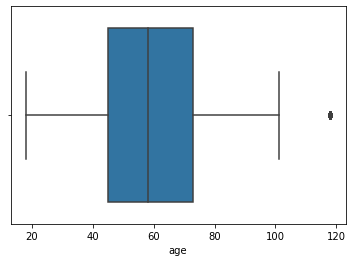

In [250]:
sns.boxplot(x=profile["age"])

Como se ve en el boxplot, las filas que contiene valores nulos, son datos erroneos ya que nos estan introduciendo informacion con outliers, es decir es muy raro que la edad de los clientes sea de 118 años, por lo tanto por lo que he mencionado anteriormente voy a eliminar todas las filas con valores nulos.

In [251]:
profile=profile.dropna()
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

#### Data Wrangling
En este paso voy a generar nuevos atributos de los datasets, con los que sacar mayor informacion y poder obtener mejores estadisticas y estructurar los datasets de una forma mas eficiente.

* Became member on  

En este proceso se va a obtener cuantos dias lleva el cliente inscrito como mienbro, con referencia a la ultima fecha de inscripcion, he realizado este proceso ya que este atributo debe dar bastante informacion de si el usuario sigue la plataforma desde hace tiempo o es nuevo.

In [252]:
last_inscription=max(profile["became_member_on"])
last_inscription=datetime.strptime(str(last_inscription), '%Y%m%d')
profile["days_inscription"]=profile["became_member_on"].map(lambda x: (last_inscription-datetime.strptime(str(x), '%Y%m%d')).days)
profile

,gender,age,id,became_member_on,income,days_inscription
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,443
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,91
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,257
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,52
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,546
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,871


* Cleaning events

La columna *event* del dataset transcript tiene una palabra que no es necesaria la cual es *offer*, por lo tanto voy a proceder con la eliminacion de esa palabra sobrante.

In [253]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [254]:
transcript["event"]=transcript["event"].map(lambda x: x.replace("offer ",""))
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


* Separar el diccionario de value en diferentes columnas

Para terminar voy a proceder con limpiar la columna de value, la cual contiene un diccionario con las ids de las ofertas, cantida de recompensa al completar una oferta y la cantidad gastada si no se ha usado ninguna oferta.  
Para ello lo que voy a realizar es coger todos estos valores y separarlos uno en cada columna es decir divire la columna value en 3 diferentes columnas : reward , offer y amount.

In [255]:
def reward(a):
    if("reward" in a.keys()):
        return a["reward"]
    return 0

def amount(a):
    if("amount" in a.keys()):
        return a["amount"]
    return 0

def offer_id(a):
    if("offer id" in a.keys()):
        return a["offer id"]
    elif("offer_id" in a.keys()):
        return a["offer_id"]
    return 0


transcript["offer"]=transcript["value"].map(offer_id)
transcript["reward"]=transcript["value"].map(reward)
transcript["amount"]=transcript["value"].map(amount)
transcript=transcript.drop(['value'], axis=1)
transcript

,person,event,time,offer,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.00
1,a03223e636434f42ac4c3df47e8bac43,received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.00
2,e2127556f4f64592b11af22de27a7932,received,0,2906b810c7d4411798c6938adc9daaa5,0,0.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0.00
4,68617ca6246f4fbc85e91a2a49552598,received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0.00
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,0,0,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,0,0,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,0,0,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,0,0,3.53


* Categorizar  


Voy a categorizar dos columnas del dataset profile las cuales son Age e Income, ya que tiene una gran variabilidad y se podria agrupar estos valores en unas pocas categorias.  
*Age : Joven (18,22) , Adulto (22,60) y Anciano (60,max).  
*Income : Low, Medium , High los valores de esta categorias se realizara con un particionado entre 3 de sus valores.

In [256]:
profile['age']=pd.cut(profile['age'], bins=[0, 22, 60, 200],labels=['Young', 'Adult', 'Elderly'])
profile['income']=pd.cut(profile['income'], bins=3,labels=['Low','Average','High'])
profile

,gender,age,id,became_member_on,income,days_inscription
1,F,Adult,0610b486422d4921ae7d2bf64640c50b,20170715,High,376
3,F,Elderly,78afa995795e4d85b5d9ceeca43f5fef,20170509,High,443
5,M,Elderly,e2127556f4f64592b11af22de27a7932,20180426,Average,91
8,M,Elderly,389bc3fa690240e798340f5a15918d5c,20180209,Low,167
12,M,Adult,2eeac8d8feae4a8cad5a6af0499a211d,20171111,Low,257
...,...,...,...,...,...,...
16995,F,Adult,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,Low,52
16996,M,Elderly,2cb4f97358b841b9a9773a7aa05a9d77,20180713,Average,13
16997,M,Adult,01d26f638c274aa0b965d24cefe3183f,20170126,Average,546
16998,F,Elderly,9dc1421481194dcd9400aec7c9ae6366,20160307,Low,871


Finalmente ahora se va a crear un unico dataset a partir de la unificación de todos estos datasets, el cual se va a ser usado para realizar las estadisticas y mas adelante para hacer el modelo predictivo.

In [257]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [258]:
transcript_df=transcript[["event","person","offer","reward","amount"]].copy()
profile_df=profile[["age","gender","id","income","days_inscription"]].copy()
portfolio_df=portfolio[["id","offer_type","duration","difficulty"]].copy()

In [259]:
df=pd.merge(transcript_df,profile_df, left_on=['person'], right_on=['id'], how='left').dropna()
values = {'offer_type': "None", 'duration': 0, 'difficulty': 0}
df=pd.merge(df,portfolio_df, left_on=['offer'], right_on=['id'], how='left').fillna(value=values)
df=df.drop(["person","offer","id_x","id_y","reward","amount"],axis=1)
df

,event,age,gender,income,days_inscription,offer_type,duration,difficulty
0,received,Elderly,F,High,443.0,bogo,7.0,5.0
1,received,Elderly,M,Average,91.0,discount,7.0,10.0
2,received,Elderly,M,Low,167.0,bogo,5.0,5.0
3,received,Adult,M,Low,257.0,informational,4.0,0.0
4,received,Elderly,F,Low,318.0,discount,10.0,20.0
...,...,...,...,...,...,...,...,...
272757,completed,Adult,F,Average,210.0,discount,10.0,10.0
272758,transaction,Elderly,M,Low,206.0,None,0.0,0.0
272759,transaction,Adult,M,Average,109.0,None,0.0,0.0
272760,transaction,Elderly,F,Low,1768.0,None,0.0,0.0


Al combinar los 3 anteriores datasets ha dado resultado este dataset:
* event 
* reward
* amount
* age
* gender
* income
* days_inscription
* offer_type
* duration
* difficulty

## Analisys Data
<a id="EDA"></a>

Ahora que se ha realizado el preprocesamiento de los datos y se ha unificado todo en un dataset, se va a realizar un analiss de datos respondiendo las siguientes preguntas:

#### 1. ¿Que evento se ha realizado con mas frecuencia?

Para responder a esta pregunta se va a obtener el porcentaje de cada evento que se ha producido y se ha representar graficamente.

In [260]:
total=df.shape[0]
porc_received=(df[df["event"]=="received"].shape[0]/total)*100
porc_completed=(df[df["event"]=="completed"].shape[0]/total)*100
porc_viewed=(df[df["event"]=="viewed"].shape[0]/total)*100
porc_transaction=(df[df["event"]=="transaction"].shape[0]/total)*100

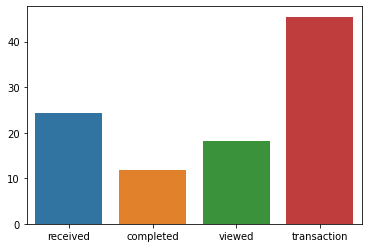

In [261]:
x=["received","completed","viewed","transaction"]
height=[porc_received,porc_completed,porc_viewed,porc_transaction]
sns.barplot(x, height)

Como se puede observar el evento mas probable es la transaction, es decir comprar productos sin usar ninguna oferta.  
Y los eventos que se usan en funcion de las ofertas es que el 25% de los eventos son la recepcion de las ofertas pero solo el 18% de los clientes ven esas ofertas y finalmente el 13% de los clientes complentan tales ofertas.  
Es decir, esto quiere decir que solo el 13% de nuestras ventas proceden de las ofertas, el cual, es un bajo porcentaje con lo que se deberia mejorar el envio de tales ofertas para captar a personas que si las completaran.

#### 2. ¿Que oferta es la que mas popular?

Para ello vamos a quedarnos con todas las ofertas que tengan como evento de completar y finalmente agruparemos por tipo de oferta para saber cuales de estas ofertas que disponemos son las mas usadas por nuestro clientes.  
Se debe recordar que el tipo de ofertas disponibles son bogo, descuento e informacional

Text(0, 0.5, 'Number of People')

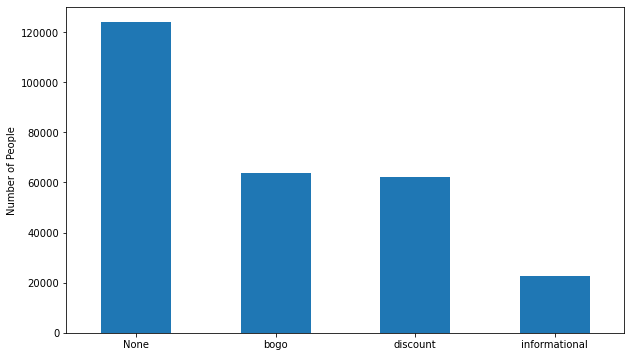

In [262]:
df.offer_type.value_counts().plot(kind='bar', rot=0, figsize=(10,6))
plt.ylabel('Number of People')

Como se puede ver en la grafica la oferta mas enviada es bogo, junto con el de descuento y muy atras esta la informacional, pero claro estos son las mas ofertas mas enviadas, pero no es lo mismo que las que se ha completado, por lo tanto ahora se va a ver que oferta es la que mas se ha completado.

Text(0, 0.5, 'Number of People')

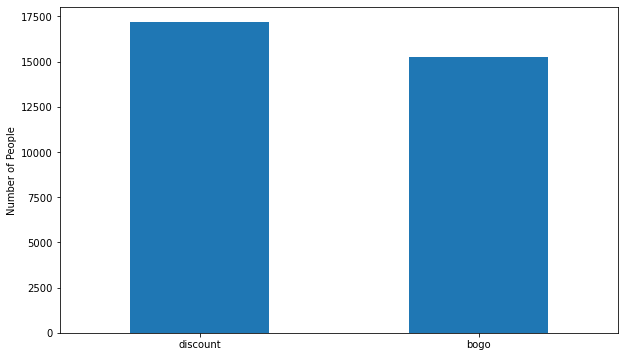

In [263]:
df[df["event"]=="completed"].offer_type.value_counts().plot(kind='bar', rot=0, figsize=(10,6))
plt.ylabel('Number of People')

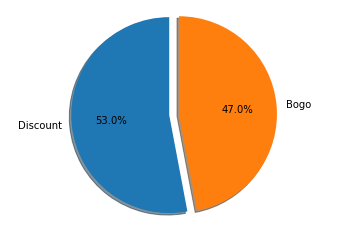

In [264]:
labels=['Discount','Bogo']
valores=df[df["event"]=="completed"].offer_type.value_counts()
values=[valores[0],  valores[1]]
explode=(0.1,0)

fig1, ax1 = plt.subplots()
ax1.pie(values,explode,labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

Como se puede observar la oferta mas completada es la de descuento aunque se envie mas ofertas de Bogo, aunque la diferencia entre su uso es de un 6% que no es mucho, con lo que a partir de esta pregunta no veria ningun cambio en esto.

#### ¿Cual es la edad mas frecuente de nuestros clientes?

Ahora se va a analizar la edad de nuestro clientes mas frecuentes.
Se debe recordar que las edades se divieron en estas categorias:  
Joven (18,22) , Adulto (22,60) y Anciano (60,max).  

Text(0, 0.5, 'Number of People')

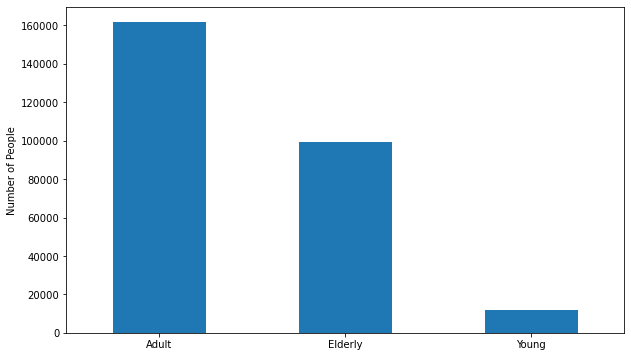

In [265]:
df["age"].value_counts().plot(kind='bar', rot=0, figsize=(10,6))
plt.ylabel('Number of People')

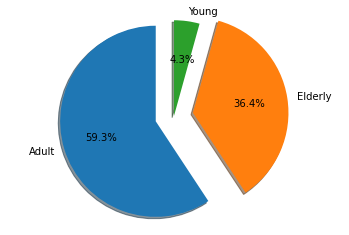

In [266]:
labels=['Adult','Elderly',"Young"]
valores=df["age"].value_counts()
values=[valores[1],  valores[2],valores[0]]
explode=(0.20,0.20,0)

fig1, ax1 = plt.subplots()
ax1.pie(values,explode,labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

Por lo que se puede observar la mayoria de nuestros clientes son personas adultas con un 60%, luego le sigue las personas ancianas con 36% y finalmente las personas jovenes con 4.3%, con lo que esto quiere decir que estamos perdiendo muchisimos clientes jovenes, con lo que se deberia llamar la atencion para intentar llamar mas a la atencion a los clientes jovenes.

#### ¿Que tipo de ofertas son mas usadas en funcion del genero?

Ahora en lugar de analizar la edad, se va a analizar el genero de nuestro clientes pero viendo que tipo de oferta usa mas cada genero, asi poder decidir si es mejor el envio de cada oferta en funcion del genero de esta persona.

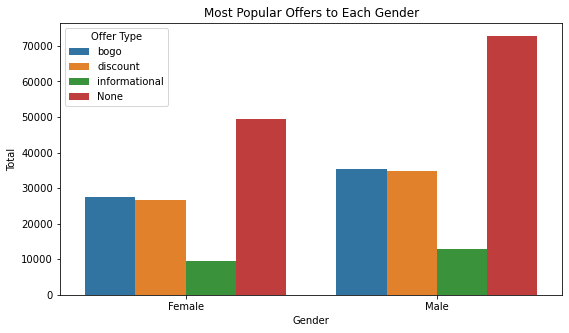

In [267]:
plt.figure(figsize=(9, 5))
g = sns.countplot(x='gender', hue="offer_type", data= df[df["gender"]!="O"])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show()

Como se puede observar el independientemente, reciben el mismo numero de oferta el genero masculino que el masculino. Por lo que no deberia aplicarse ningun cambio para mejorar la recepcion de estas ofertas.  
Lo unico que si nos fijamos que hay un incremento de que los hombres no usan ninguna oferta en comparacion a las mujeres.

#### ¿Cuales el rango de ingresos mas frecuente de los clientes?

Text(0, 0.5, 'Number of People')

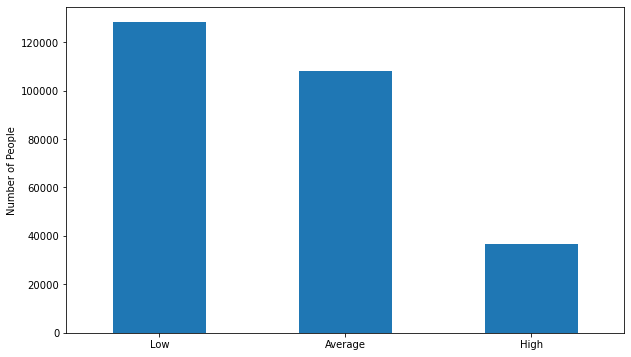

In [268]:
df["income"].value_counts().plot(kind='bar', rot=0, figsize=(10,6))
plt.ylabel('Number of People')

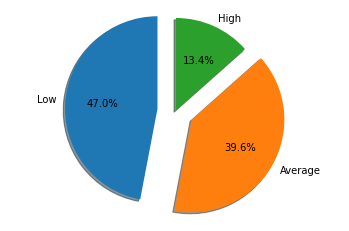

In [269]:
labels=['Low','Average',"High"]
valores=df["income"].value_counts()
values=[valores[0],  valores[1],valores[2]]
explode=(0.20,0.20,0)

fig1, ax1 = plt.subplots()
ax1.pie(values,explode,labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

Por lo que estamos viendo nuestros clientes estan concentrado en un nivel bajo o medio de ingresos mientras que los que tienen un alto nivel de ingresos no nos proporcionan compras, con lo que deberiamos ver el caso en el que estos clientes no se sienten comodos en realizar compras y asi poder mejorar el ratio de ventas en clientes con alta tasa de ingresos.

## Model Data
<a id="model"></a>

In [270]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

Antes de proceder a crear el modelo y a nombrar las metricas que se van a usar para saber la eficiencia de nuestro modelo, se va a proceder con unos cambios en el dataset para poder proceder con la creacion del modelo de una forma eficiente y limpia.  
Primero se va a realizar obtener la etiqueta que queremos predecir, la cual sera un valor binario {0,1}, en funcion de si la oferta en ese momento se ha completado o no.  
Despues se ha realizara un One Hot Encoding, para transformas los valores categoricos en valores binarios para poder ser procesados bien en el modelo predictivo y que no afecten estos valores en los pesos del modelo.  
Y finalmente normalizare los valores numericos los cuales son : reward, amount, days_inscription, duration y difficulty.

In [271]:
df["Y"]=df["event"].map(lambda x: 1 if x=="completed" else 0)
df.drop(['event'],axis=1, inplace=True)
columns_dummys=["income","gender","offer_type","age"]
for dummy in columns_dummys:
    df = pd.concat([df,pd.get_dummies(df[dummy], prefix=dummy)],axis=1)
    df.drop([dummy],axis=1, inplace=True)
df.head()

,days_inscription,duration,difficulty,Y,income_Low,income_Average,income_High,gender_F,gender_M,gender_O,offer_type_None,offer_type_bogo,offer_type_discount,offer_type_informational,age_Young,age_Adult,age_Elderly
0,443.0,7.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
1,91.0,7.0,10.0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2,167.0,5.0,5.0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,257.0,4.0,0.0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
4,318.0,10.0,20.0,0,1,0,0,1,0,0,0,0,1,0,0,0,1


In [272]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ["days_inscription", "duration","difficulty"]
df[features] = scaler.fit_transform(df[features])
df.head()

,days_inscription,duration,difficulty,Y,income_Low,income_Average,income_High,gender_F,gender_M,gender_O,offer_type_None,offer_type_bogo,offer_type_discount,offer_type_informational,age_Young,age_Adult,age_Elderly
0,0.243006,0.7,0.25,0,0,0,1,1,0,0,0,1,0,0,0,0,1
1,0.049918,0.7,0.50,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2,0.091607,0.5,0.25,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,0.140976,0.4,0.00,0,1,0,0,0,1,0,0,0,0,1,0,1,0
4,0.174438,1.0,1.00,0,1,0,0,1,0,0,0,0,1,0,0,0,1


Ahora que ya se tiene el dataset limpio y normalizado voy a definir las metricas.   
Metrices  
In order to evaluate our model performance we are using the accuracy, matriz de confusion y con ella obtendremos el F1-Score y la curva ROC.  

We are using the simple classification problem, el cual la etiqueta sera binaria {0,1}, en funcion si el evento ha sido completado o no.  
 
To know how our model is performing we will compare our model usando las metricas que he mencionado anteriormente.
* Accuracy
* F1-Score
* Curva ROC  

Para empezar se va a dividir el dataset en 2 partes las cuales son :
* Training : dataset de entrenamiento del modelo.
* Test : dataset final con el que obtendremos resultados de las metricas como si fuera un caso externo.

In [273]:
train, test = train_test_split(df, test_size = 0.33, random_state=42)

In [274]:
train["Y"].value_counts()

0    160918
1     21832
Name: Y, dtype: int64

In [275]:
train["Y"].value_counts()/train.shape[0]

0    0.880536
1    0.119464
Name: Y, dtype: float64

Como se puede observar el dataset que tenemos esta desbalanceado, es decir que tenemos el 88% del dataset de la clase 0, es decir no compleado y solo disponemos de 12% restante de la clase 1, el cual queremos predecir.  
Esto quiere decir que nuestro modelo tiene pocos ejemplos para aprender de la clase que queremos predecir y sobreajustara a la clase 0, con lo que voy a balancearte este dataset, para ello voy a replicar casos de la clase 1 hasta tener 40000 ejemplos, y voy a eliminar ejemplos de la clase 0 hasta tener igualmente 40000.  
Asi finalmente tendremos un dataset completamente balanceado.

In [276]:
from sklearn.utils import resample
# Upsample minority class
df_minority=train[train["Y"]==1]
df_majority=train[train["Y"]==0]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=40000,    # to match majority class
                                 random_state=123)
# Downsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=40000,    # to match majority class
                                 random_state=123)
train= pd.concat([df_minority_upsampled, df_majority_downsampled])

In [277]:
train["Y"].value_counts()

1    40000
0    40000
Name: Y, dtype: int64

Separo los datasets en etiqueta y entrada, para luego pasarselo a los modelos de prediccion para entrenarlos.

In [278]:
y_train=train["Y"]
X_train=train.drop(["Y"],axis=1)
X_test=test.drop(["Y"],axis=1)
y_test=test["Y"]

### MODELS

Voy a crear 4 modelos con diferentes configuraciones y distintos modelos predictivos y evaluarlos para luego coger el mejor de ellos.  
Para ello, voy a crear una funcion llamada evaluate, el cual se le pasara el dataset de entrenamiento y testeo, junto con el modelo y los posibles parametros que se quieren analizar de ese modelo. Luego vamos a crear una busqueda del modelo con los mejores parametros, y a partir de ese modelo se entrenara y se predicira con el dataset de test y se obtendra el valor de las metricas que se ha mencionado anteriormente.  
* Accuracy
* F1-Score
* Curva ROC  


In [279]:
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
accuracy=[]
f1=[]
auc=[]
def evaluate(X_train,X_test,Y_train,Y_test,parameters,model):
    clf = GridSearchCV(model,param_grid=parameters)
    clf.fit(X_train,Y_train)
    y_pred=clf.predict(X_test)
    accurracy=accuracy_score(y_test, y_pred)*100
    f1=f1_score(y_test, y_pred)*100
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot([0, 1], [0, 1], 'k--')
    auc = roc_auc_score(y_test, y_pred)*100
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    print("Accuracy : {} , F1 : {}".format(accurracy,f1))
    return clf,accurracy,f1,auc


#### RandomForestClassifier

Random Forest es un algoritmo de clasificacion que esta formado por un conjunto de arboles de decision. Este algoritmo para generar cada arbol usa bagging y elige las caracteristicas de forma aleatoria, esto lo que hace es crear un conjutno de arboles no correlados, los cuales nos va a permitir obtener mayor acierto que un simple arbol.

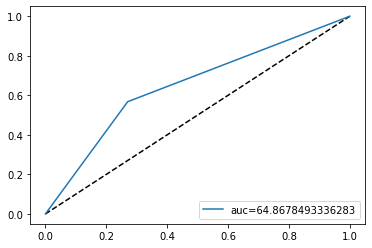

Accuracy : 71.05941430031551 , F1 : 31.623707281222114


In [280]:
from sklearn.ensemble import RandomForestClassifier
parameters = {
        'n_estimators': [3,5, 15],
        'max_features' : ["sqrt", "log2"]
    }
clf = RandomForestClassifier(random_state=42)
clf,accurracy_forest,f1_forest,auc_forest=evaluate(X_train,X_test,y_train,y_test,parameters,clf)
accuracy.append(accurracy_forest)
f1.append(f1_forest)
auc.append(auc_forest)

Usando este algoritmo hemos obtenido los siguientes resultados :
* Accuracy : 71.65 %
* F1 : 71.05 %
* AUC : 31.62 %

#### SVM

SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo más amplios posibles mediante un hiperplano (vector soporte) de separación definido como el separador entre las 2 clases. Cuando estamos en la fase de entrenamientos y las nuevas muestras no se ponen correspondencia con dicho modelo, se realiza un cambio de este hiperplano para poder ajustarse a los nuevos puntos.

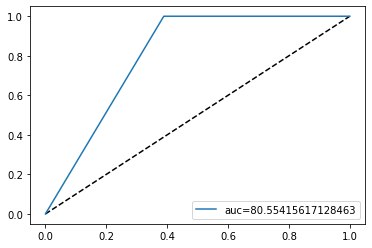

Accuracy : 65.69346309380971 , F1 : 40.73391678182097


In [281]:
from sklearn import svm
parameters = {
        'kernel': ["linear", "poly", "rbf"],
    }
clf = svm.SVC(random_state=42,class_weight='balanced')
clf,accurracy_svc,f1_svc,auc_svc=evaluate(X_train,X_test,y_train,y_test,parameters,clf)
accuracy.append(accurracy_svc)
f1.append(f1_svc)
auc.append(auc_svc)

Usando este algoritmo hemos obtenido los siguientes resultados :
* Accuracy : 65.69 %
* F1 : 40.73 %
* AUC : 80.55 %

#### KNN

Es un método de clasificación no paramétrico, que se encarga de clasificar los valores de test, cogiendo uno a uno estos valores y buscar los k vecinos mas cercanos a este punto y en funcion de sus clases, se clasificara como la clase mayoritaria.

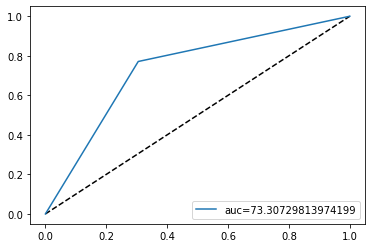

Accuracy : 70.40061325156645 , F1 : 38.05250063940105


In [282]:
from sklearn.neighbors import KNeighborsClassifier
parameters = {
        'algorithm': ["ball_tree", "kd_tree"],
        'n_neighbors' : [3,5,10]
    }
clf = KNeighborsClassifier()
clf,accurracy_knn,f1_knn,auc_knn=evaluate(X_train,X_test,y_train,y_test,parameters,clf)
accuracy.append(accurracy_knn)
f1.append(f1_knn)
auc.append(auc_knn)

Usando este algoritmo hemos obtenido los siguientes resultados :
* Accuracy : 70.4 %
* F1 : 38.05 %
* AUC : 73.3 %

#### Logistic Regression

La regresión logística es un tipo de análisis de regresión utilizado para predecir el resultado de una variable categórica en función de la probabilidad de que ocurra la clase o no.

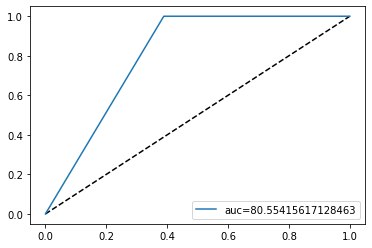

Accuracy : 65.69346309380971 , F1 : 40.73391678182097


In [283]:
from sklearn.linear_model import LogisticRegression
parameters = {
        'solver': ["newton-cg", "sag"]
    }
clf = LogisticRegression(random_state=42)
clf,accurracy_log,f1_log,auc_log=evaluate(X_train,X_test,y_train,y_test,parameters,clf)
accuracy.append(accurracy_log)
f1.append(f1_log)
auc.append(auc_log)

Usando este algoritmo hemos obtenido los siguientes resultados :
* Accuracy : 65.69 %
* F1 : 40.73 %
* AUC : 80.55 %

#### RESUMEN

Ahora se va a juntar todos los resultados obtenidos de cada modelo predictivo y se va elegir el mejor modelo que se usara para predecir si un usuario va a completar una oferta dada o no.

In [285]:

results = [accuracy, f1,auc]
models_re=["RandomForestClassifier","SVM","KNN","Logistic Regression"]

df_results = pd.DataFrame(results, columns = models_re, index=['Accuracy', 'F1','AUC'])
df_results

,RandomForestClassifier,SVM,KNN,Logistic Regression
Accuracy,71.059414,65.693463,70.400613,65.693463
F1,31.623707,40.733917,38.052501,40.733917
AUC,64.867849,80.554156,73.307298,80.554156


Como se puede observar tenemos un empate entre el algoritmo de regresión logistica y el SVM, por lo tanto, eligire el SVM, por el caso que tenemos el parametro de que trabaje con datos no balanceados y tiene un mejor comportamiento.  
Por lo tanto, finalmente usaremos el modelo del SVM para predecir si un cliente va a completar o no una oferta.

## Conclusion
<a id="conclusion"></a>